### Inference Example

The following example demonstrates how to use PDEformer to predict the solution of a given PDE. Before running, you need to download the pre-trained PDEformer weights and modify the `model/load_ckpt` parameter in `configs/inference/model-M.yaml` to the corresponding path of the weight file.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mindspore import context
from src import load_config, get_model, PDENodesCollector, sample_grf
from src.inference import infer_plot_2d, x_fenc, y_fenc, interp_fenc

# basic setting
context.set_context(mode=context.GRAPH_MODE, device_target="CPU")
config = load_config("configs/inference/model-M.yaml")
model = get_model(config)

#### Solving the Two-Dimensional Nonlinear Conservation Law Equation

- PDE Form: $u_{t} + (u^2)_x + (-0.3u)_y = 0$

- Initial Condition: $u(0,x,y) = \exp(-2(x-\frac{1}{2})^2-8(y-\frac{1}{2})^2)$

- Boundary Condition: Periodic boundary conditions


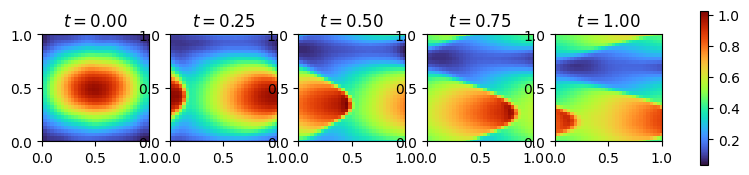

In [2]:
# define the PDE to be solved
pde = PDENodesCollector()
u = pde.new_uf()
u_ic = np.exp(-4 * (x_fenc - 0.5)**2 - 8 * (y_fenc - 0.5)**2)
pde.set_ic(u, u_ic, x=x_fenc, y=y_fenc)
pde.sum_eq0(pde.dt(u), pde.dx(pde.square(u)), pde.dy(-0.3 * u))

# inference with resolution 32, and plot the results
pde_dag = pde.gen_dag(config)
x_plot, y_plot = np.meshgrid(np.linspace(0, 1, 32), np.linspace(0, 1, 32), indexing="ij")
u_pred = infer_plot_2d(model, pde_dag, x_plot, y_plot)

#### Solving the Viscous Convection-Diffusion Equation

- PDE Form: $u_{t} + (\frac{1}{2}u)_x + f(x,y) - 3\times 10^{-3}\Delta u = 0$

- Initial Condition: $u(0,x,y) = \sin(2\pi x)\cos(4\pi y)$

- Source Term: $f(x,y) = \exp(-32(x-\frac{1}{2})^2-32(y-\frac{1}{2})^2)$

- Boundary Condition: Periodic boundary conditions


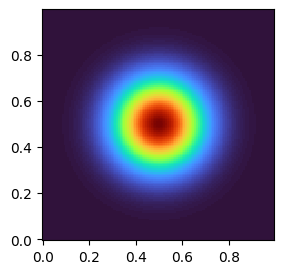

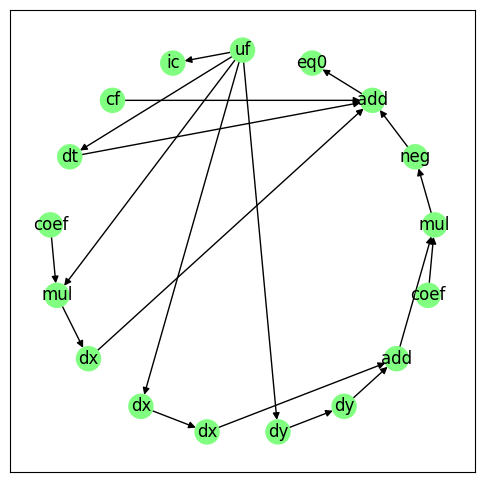

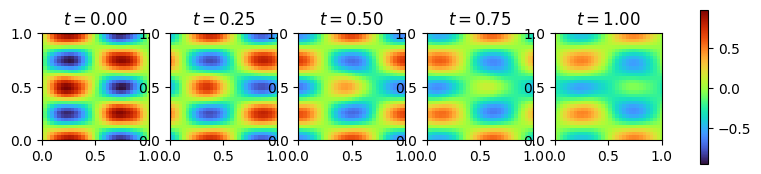

In [3]:
u_ic = np.sin(2 * np.pi * x_fenc) * np.cos(4 * np.pi * y_fenc)
f_arr = np.exp(-32 * (x_fenc - 0.5)**2 - 32* (y_fenc - 0.5)**2)
# plot source term
plt.figure(figsize=(3, 3))
plt.pcolormesh(x_fenc, y_fenc, f_arr, cmap="turbo")

# define PDE
pde = PDENodesCollector()
u = pde.new_uf()
pde.set_ic(u, u_ic, x=x_fenc, y=y_fenc)
f = pde.new_coef_field(f_arr, x=x_fenc, y=y_fenc)
pde.sum_eq0(u.dt, (0.5 * u).dx, f, -(3e-3 * (u.dx.dx + u.dy.dy)))

# inference and plot
pde_dag = pde.gen_dag(config)
pde_dag.plot(hide='aux')  # plot the computational graph
u_pred = infer_plot_2d(model, pde_dag, x_plot, y_plot)

The solution for $t > 1$ is obtained through iterative extrapolation:


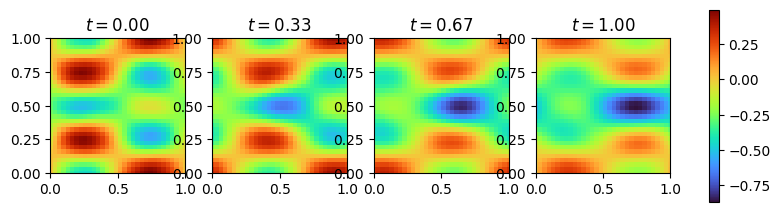

In [4]:
# re-define PDE during rollout predictions
pde = PDENodesCollector()
u = pde.new_uf()
u_ic = interp_fenc(u_pred[-1])
pde.set_ic(u, u_ic, x=x_fenc, y=y_fenc)
f = pde.new_coef_field(f_arr, x=x_fenc, y=y_fenc)
pde.sum_eq0(u.dt, (0.5 * u).dx, f, -(3e-3 * (u.dx.dx + u.dy.dy)))

# inference and plot
pde_dag = pde.gen_dag(config)
u_pred = infer_plot_2d(model, pde_dag, x_plot, y_plot, snap_t=np.linspace(0, 1, 4))

#### Damped Wave Equation

- PDE Form: $u_{tt} + 0.3u_t -\Delta u = 0$

- Initial Condition: $u(0,x,y) = g(x,y)$, where $g(x,y)$ is a Gaussian Random Field (GRF), and $u_t(0,x,y)=0$

- Boundary Condition: Periodic boundary conditions


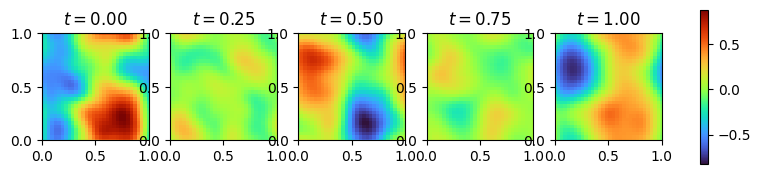

In [5]:
# define PDE
u_ic = sample_grf()
pde = PDENodesCollector()
u = pde.new_uf()
pde.set_ic(u, u_ic, x=x_fenc, y=y_fenc)
pde.set_ic(u.dt, 0, x=x_fenc, y=y_fenc)
pde.sum_eq0(u.dt.dt, 0.3 * u.dt, -(u.dx.dx + u.dy.dy))

# inference and plot
pde_dag = pde.gen_dag(config)
u_pred = infer_plot_2d(model, pde_dag, x_plot, y_plot)

#### Conservative Variant of Two-Dimensional Viscous Burgers' Equation

- PDE Form: 
  $$u_t + (u^2)_x + (uv)_y - 10^{-3}\Delta u = 0,$$
  $$v_t + (uv)_x + (v^2)_y - 10^{-3}\Delta v = 0$$

- Initial Condition: 
  $u(0,x,y), v(0,x,y)$ are both Gaussian Random Fields (GRF).

- Boundary Condition: Periodic boundary conditions


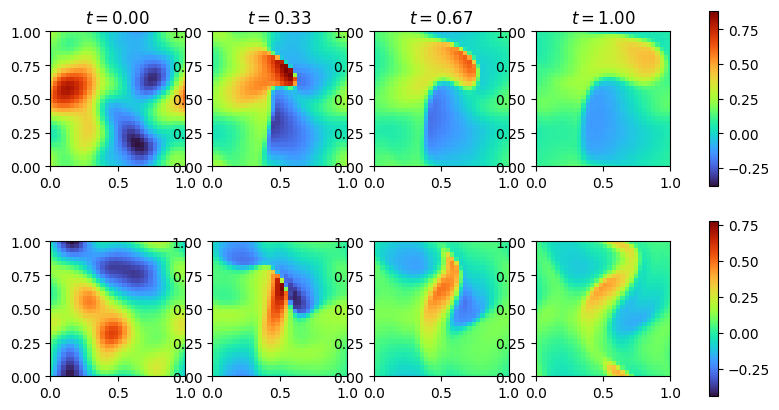

In [6]:
u_ic, v_ic = sample_grf(2)
pde = PDENodesCollector()
u = pde.new_uf()
v = pde.new_uf()
pde.set_ic(u, u_ic, x=x_fenc, y=y_fenc)
pde.set_ic(v, v_ic, x=x_fenc, y=y_fenc)
pde.sum_eq0(u.dt, (u * u).dx, (u * v).dy, -(1e-3 * (u.dx.dx + u.dy.dy)))
pde.sum_eq0(v.dt, (u * v).dx, (v * v).dy, -(1e-3 * (v.dx.dx + v.dy.dy)))
pde_dag = pde.gen_dag(config)
u_pred = infer_plot_2d(model, pde_dag, x_plot, y_plot, snap_t=np.linspace(0, 1, 4))

#### Two-Dimensional Incompressible NS Equation (Conservation Form)

- PDE Form: 
  $$u_t + (u^2)_x + (uv)_y + p_x - 10^{-3}\Delta u = 0,$$
  $$v_t + (uv)_x + (v^2)_y + p_y - 10^{-3}\Delta v = 0,$$
  $$u_x + v_y = 0$$

- Initial Condition: 
  $u(0,x,y), v(0,x,y)$ are both Gaussian Random Fields (GRF).

- Boundary Condition: Periodic boundary conditions


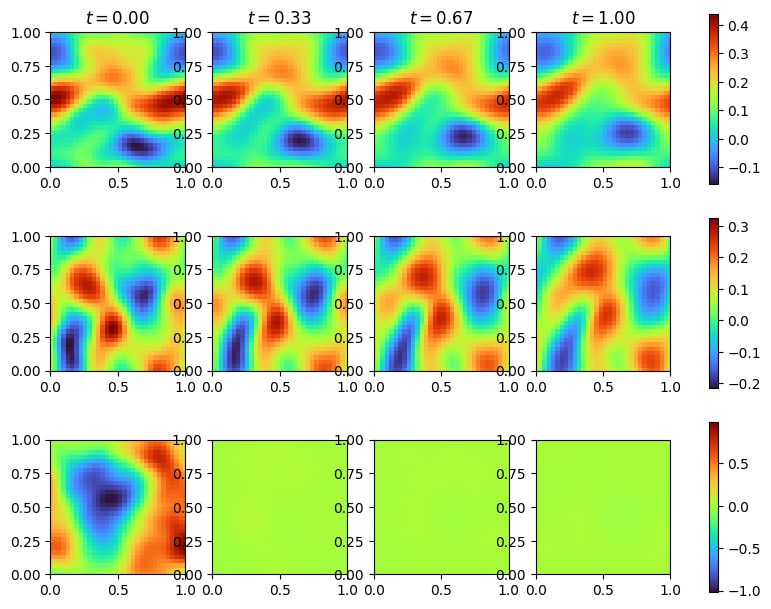

In [7]:
pde = PDENodesCollector()
u = pde.new_uf()
v = pde.new_uf()
p = pde.new_uf()
pde.set_ic(u, u_ic, x=x_fenc, y=y_fenc)
pde.set_ic(v, v_ic, x=x_fenc, y=y_fenc)
pde.sum_eq0(u.dt, (u * u).dx, (u * v).dy, p.dx, -(1e-3 * (u.dx.dx + u.dy.dy)))
pde.sum_eq0(v.dt, (u * v).dx, (v * v).dy, p.dy, -(1e-3 * (v.dx.dx + v.dy.dy)))
pde.sum_eq0(u.dx, v.dy)
pde_dag = pde.gen_dag(config)
u_pred = infer_plot_2d(model, pde_dag, x_plot, y_plot, snap_t=np.linspace(0, 1, 4))

#### Specification of Complex Domains and Boundary Conditions

- For non-periodic boundaries, it is necessary to explicitly specify the domain of the unknown field variables and the location of the boundaries.
- Both the domain and boundary locations can be represented using Signed Distance Functions (SDF). The SDF of a set $S$ is defined as 
  $$\mathrm{SDF}_S(r) = d(r,S) - d(r,S^c),$$ 
  where $r = (x,y)$. This function is negative inside $S$, positive outside $S$, and zero on the boundary of $S$.
- If the domain remains a rectangular region with periodic boundaries along one axis, the SDF should only account for non-periodic boundaries, ignoring the periodic ones during computation.


#### Convection-Diffusion Equation with Periodic + Dirichlet Boundary Conditions

- PDE Form: 
  $$u_{t} + (-0.2u)_x + (0.5u^2)_y - 3\times 10^{-3}\Delta u = 0$$

- Initial Condition: 
  $$u(0,x,y) = \sin(2\pi x)\cos(4\pi y)$$

- Boundary Condition: 
  - Periodic boundaries on the top and bottom sides of the square region.
  - Dirichlet condition on the left boundary: $u|_L = 0$.
  - Modified Dirichlet condition on the right boundary: $(u + g(x,y))|_R = 0$, where 
    $$g(x,y) = \sin(2\pi y).$$


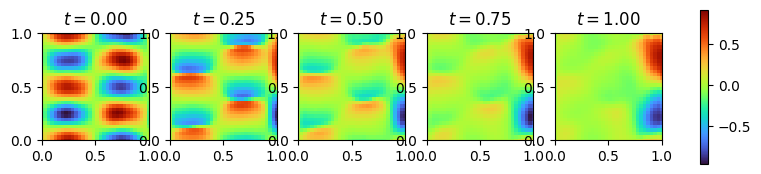

In [8]:
# prepare IC and domain
u_ic = np.sin(2 * np.pi * x_fenc) * np.cos(4 * np.pi * y_fenc)
pde = PDENodesCollector()
boundary_l = pde.new_domain(sdf_values=x_fenc, x=x_fenc, y=y_fenc)
boundary_r = pde.new_domain(1 - x_fenc, x=x_fenc, y=y_fenc)
domain = pde.new_domain(np.maximum(-x_fenc, x_fenc - 1), x=x_fenc, y=y_fenc)

# specify PDE and BC
u = pde.new_uf(domain)
pde.set_ic(u, u_ic, x=x_fenc, y=y_fenc)
pde.sum_eq0(u.dt, (-0.2 * u).dx, (0.5 * u.square).dy, -(3e-3 * (u.dx.dx + u.dy.dy)))
pde.bc_sum_eq0(boundary_l, u)
g = pde.new_coef_field(np.sin(2 * np.pi * y_fenc), x=x_fenc, y=y_fenc)
pde.bc_sum_eq0(boundary_r, u, g)

# inference and plot
pde_dag = pde.gen_dag(config)
u_pred = infer_plot_2d(model, pde_dag, x_plot, y_plot)

#### Wave Equation with Periodic + Neumann Boundary Conditions

- PDE Form: 
  $$u_{tt} - \nabla\cdot(c^2\nabla u) = 0,$$
  where \(c^2 = 2\).

- Initial Condition: 
  $$u(0,x,y) = \sin(2\pi x)\cos(4\pi y), \quad u_t(0,x,y) = 0.$$

- Boundary Condition: 
  - Periodic boundaries on the top and bottom sides of the square region.
  - Neumann boundary condition on the left and right boundaries: 
    $$\frac{\partial}{\partial n}u|_{LR} = 0.$$


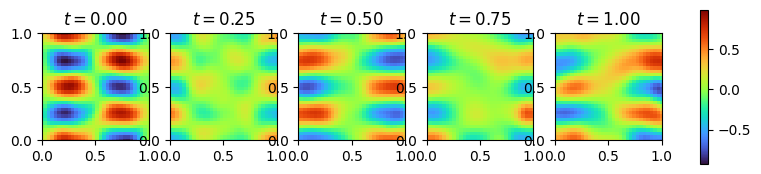

In [9]:
pde = PDENodesCollector(dim=2)
domain = pde.new_domain(np.maximum(-x_fenc, x_fenc - 1), x=x_fenc, y=y_fenc)
u = pde.new_uf(domain)
pde.set_ic(u, u_ic, x=x_fenc, y=y_fenc)
pde.set_ic(u.dt, 0, x=x_fenc, y=y_fenc)
c2 = pde.new_coef(2)
pde.sum_eq0(u.dt.dt, -((c2 * u.dx).dx + (c2 * u.dy).dy))
boundary_lr = pde.new_domain(np.minimum(x_fenc, 1 - x_fenc), x=x_fenc, y=y_fenc)
pde.bc_sum_eq0(boundary_lr, pde.dn_sum_list(u, domain))
pde_dag = pde.gen_dag(config)
u_pred = infer_plot_2d(model, pde_dag, x_plot, y_plot)

#### Mur Boundary Wave Equation on a Circular Domain

- Domain Definition: The domain $\Omega$ is a disk with center at $(0.5, 0.6)$ and radius $0.4$.

- PDE Form: 
  $$u_{tt} - c^2 \Delta u = 0,$$
  where \( c = 0.7 \).

- Initial Condition: 
  $$u(0,x,y) = \sin(2\pi x)\cos(4\pi y), \quad u_t(0,x,y) = 0.$$

- Boundary Condition: 
  Mur (Absorbing) boundary condition: 
  $$\left(u_t + c \frac{\partial}{\partial n}u \right)\bigg|_{\partial \Omega} = 0.$$


/home/liuzining/codes/pdeformer2d/src/utils/visual.py:478: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  vmin=vmin, vmax=vmax, cmap="turbo")


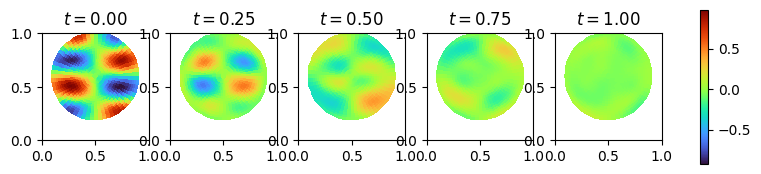

In [10]:
# define disk-shaped domain with polar coordinates
x0, y0, r0 = 0.5, 0.6, 0.4
disk_sdf = np.sqrt((x_fenc - x0)**2 + (y_fenc - y0)**2) - r0
r = r0 * np.linspace(0, 1, 16)**0.75
theta = np.linspace(-np.pi, np.pi, 64)
r, theta = np.meshgrid(r, theta, indexing="ij")
x_disk = x0 + r * np.cos(theta)
y_disk = y0 + r * np.sin(theta)

# define PDE and inference
pde = PDENodesCollector(dim=2)
domain = pde.new_domain(disk_sdf, x=x_fenc, y=y_fenc)
u = pde.new_uf(domain)
pde.set_ic(u, u_ic, x=x_fenc, y=y_fenc)
pde.set_ic(u.dt, 0, x=x_fenc, y=y_fenc)
c = 0.7
pde.sum_eq0(u.dt.dt, -(c**2 * (u.dx.dx + u.dy.dy)))
boundary = pde.new_domain(np.abs(disk_sdf), x=x_fenc, y=y_fenc)
pde.bc_sum_eq0(boundary, [u.dt] + pde.dn_sum_list(u, domain, coef=c))
pde_dag = pde.gen_dag(config)
_ = infer_plot_2d(model, pde_dag, x_disk, y_disk)

#### Shallow Water Equations (Convection Form)

- PDE Form: 
  $$h_t + (hu)_x + (hv)_y = 0,$$
  $$u_t + uu_x + vu_y + gh_x = 0,$$
  $$v_t + uv_x + vv_y + gh_y = 0,$$
  where \( g = 0.1 \).

- Initial Condition: 
  $$h(0,x,y) = \frac{3}{2} + \frac{1}{2} \sin(2\pi x)\sin(2\pi y),$$
  $$u(0,x,y) = v(0,x,y) = 0.$$

- Boundary Condition: Periodic boundary conditions


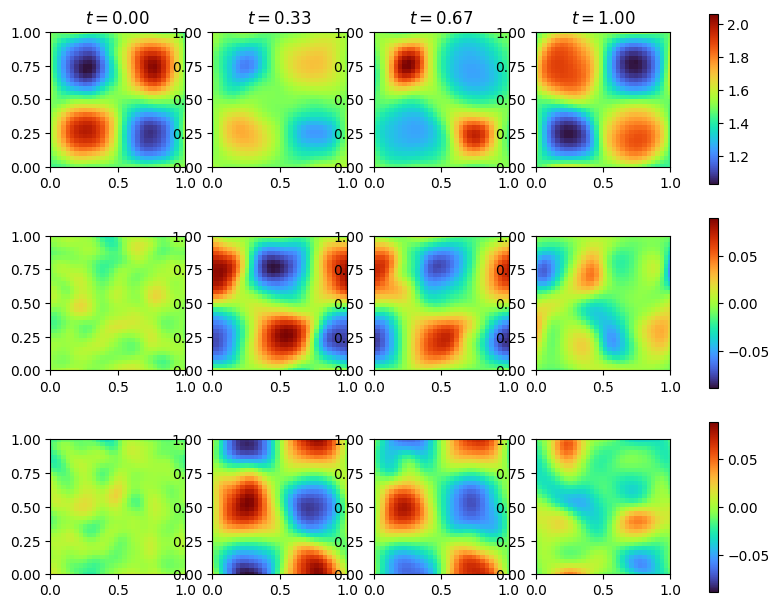

In [11]:
h_ic = 1.5 + 0.5 * np.sin(2 * np.pi * x_fenc) * np.sin(2 * np.pi * y_fenc)
g = 0.1
pde = PDENodesCollector()
h = pde.new_uf()
u = pde.new_uf()
v = pde.new_uf()
pde.set_ic(h, h_ic, x=x_fenc, y=y_fenc)
pde.set_ic(u, 0, x=x_fenc, y=y_fenc)
pde.set_ic(v, 0, x=x_fenc, y=y_fenc)
pde.sum_eq0(h.dt, (h * u).dx, (h * v).dy)
pde.sum_eq0(u.dt, u * u.dx, v * u.dy, g * h.dx)
pde.sum_eq0(v.dt, u * v.dx, v * v.dy, g * h.dy)
pde_dag = pde.gen_dag(config)
u_pred = infer_plot_2d(model, pde_dag, x_plot, y_plot, snap_t=np.linspace(0, 1, 4))